In [29]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
from skimage.io import imread, imsave
from skimage import transform
from skimage.filters import threshold_otsu, threshold_local
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import os

NUM_CLASSES = 2
TARGET_TITLES = []
TARGET_IDS = {}
IMG_ROWS, IMG_COLS, DEPTH = 150, 150, 1

BATCH_SIZE = 128
EPOCHS = 50
INPUT_SHAPE = ()

def display_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.show()

def file_number(path):
    return len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])

def load_nist_data():
    global TARGET_TITLES, TARGET_IDS
    
    path_to_data = 'sd06/'
    fl = open(path_to_data + 'target_list.txt', 'r')
    
    i = 0
    for line in fl:
        ln = line.strip('\n')
        TARGET_TITLES.append(ln)
        TARGET_IDS[ln] = i
        i += 1
        
    fl.close()
        
    images = np.array([])
    targets = []
    
    for i in range(50):
        path_to_sample_pack = path_to_data + 'r{0:04d}'.format(i)
        sample_number = file_number(path_to_sample_pack)//2
        path_to_sample_prefix = None
        
        for j in range(sample_number):
            path_to_sample_prefix = path_to_sample_pack + '/' + 'r{0:04d}_{1:02d}'.format(i, j)
            
            new_img = transform.resize(imread(path_to_sample_prefix + '.png'), (150, 150))
            
            if len(images) == 0:
                images = np.array([new_img])
            else:
                images = np.append(images, [new_img], axis=0)
            
            fl = open(path_to_sample_prefix + '.fmt')
            target = fl.readline().strip('\n')
            fl.close()
            targets.append(TARGET_IDS[target])
    
    return images, targets

def prepare_nist_data(images, targets):
    global INPUT_SHAPE
    
    x_train, x_test, y_train, y_test = train_single_split(images, targets)
    #x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.1)
    
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], DEPTH, IMG_ROWS, IMG_COLS)
        x_test = x_test.reshape(x_test.shape[0], DEPTH, IMG_ROWS, IMG_COLS)
        INPUT_SHAPE = (DEPTH, IMG_ROWS, IMG_COLS)
    else:
        x_train = x_train.reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, DEPTH)
        x_test = x_test.reshape(x_test.shape[0], IMG_ROWS, IMG_COLS, DEPTH)
        INPUT_SHAPE = (IMG_ROWS, IMG_COLS, DEPTH)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    x_train -= 0.5
    x_test -= 0.5
    
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    return (x_train, y_train), (x_test, y_test)

def load_nsu_data(augmentation=False):
    global TARGET_TITLES, TARGET_IDS
    
    path_to_data = 'nsu/'
        
    images = np.array([]) 
    targets = []
    samples_number = file_number(path_to_data) - 1
    
    for i in range(samples_number):
        path_to_sample = path_to_data + str(i) + '.jpg'
            
        new_img = transform.resize(imread(path_to_sample), (150, 150))
            
        if len(images) == 0:
            images = np.array([new_img])
        else:
            images = np.append(images, [new_img], axis=0)
    
    fl = open(path_to_data + 'targets.txt', 'r')
    for line in fl:
        targets.append(int(line))
    fl.close()
    
    return images, targets

def prepare_nsu_data(images, targets):
    global INPUT_SHAPE
    
    x_train, x_test, y_train, y_test = train_single_split(images, targets)
    #x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.1)
    
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], DEPTH, IMG_ROWS, IMG_COLS)
        x_test = x_test.reshape(x_test.shape[0], DEPTH, IMG_ROWS, IMG_COLS)
        INPUT_SHAPE = (DEPTH, IMG_ROWS, IMG_COLS)
    else:
        x_train = x_train.reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, DEPTH)
        x_test = x_test.reshape(x_test.shape[0], IMG_ROWS, IMG_COLS, DEPTH)
        INPUT_SHAPE = (IMG_ROWS, IMG_COLS, DEPTH)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    x_train -= 0.5
    x_test -= 0.5
    
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    return (x_train, y_train), (x_test, y_test)


def train_single_split(images, targets):
    #take only one sample per class
    enough_samples = [False] * NUM_CLASSES
    
    x_train, x_test, y_train, y_test = None, None, np.array([]), np.array([])
    
    for i in range(len(images)):
        target_id = targets[i]
        if enough_samples[target_id] is False:
            enough_samples[target_id] = True
            if x_train is None:
                x_train = np.array([images[i]])
            else:
                x_train = np.append(x_train, [images[i]], axis=0)
                
            y_train = np.append(y_train, targets[i])
        else :
            if x_test is None:
                x_test = np.array([images[i]])
            else:
                x_test = np.append(x_test, [images[i]], axis=0)
            y_test = np.append(y_test, targets[i])
    
    
    return x_train, x_test, y_train, y_test
    


images, targets = load_nsu_data()
(x_train, y_train), (x_test, y_test) = prepare_nsu_data(images, targets)

model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = (7, 7), 
                 activation ='relu', input_shape = INPUT_SHAPE))
model.add(MaxPool2D(pool_size=(4, 4)))
model.add(Conv2D(filters = 50, kernel_size = (5, 5), activation ='relu'))
model.add(MaxPool2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(1000, activation = "relu"))
model.add(Dense(1000, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer='sgd',
            metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs = 400)

score = model.evaluate(x_test, y_test)
print(score)

model.save('nsu_docs_classifier.h5')


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/400
2/2 [==============================] - 0s 200ms/step - loss: 0.6705 - acc: 0.5000
Epoch 2/400
2/2 [==============================] - 0s 47ms/step - loss: 0.6890 - acc: 1.0000
Epoch 3/400
2/2 [==============================] - 0s 45ms/step - loss: 0.6870 - acc: 0.5000
Epoch 4/400
2/2 [==============================] - 0s 49ms/step - loss: 0.6260 - acc: 1.0000
Epoch 5/400
2/2 [==============================] - 0s 50ms/step - loss: 0.6669 - acc: 0.5000
Epoch 6/400
2/2 [==============================] - 0s 46ms/step - loss: 0.6653 - acc: 0.5000
Epoch 7/400
2/2 [==============================] - 0s 51ms/step - loss: 0.7164 - acc: 0.0000e+00
Epoch 8/400
2/2 [==============================] - 0s 49ms/step - loss: 0.6764 - acc: 0.5000
Epoch 9/400
2/2 [==============================] - 0s 46ms/step - loss: 0.6366 - acc: 1.0000
Epoch 10/400
2/2 [==============================] - 0s 51ms/step - loss: 0.6071 - acc: 1.0000
Epoch 11/400
2/2 [==============================] - 0s 46ms/step

Epoch 89/400
2/2 [==============================] - 0s 48ms/step - loss: 0.0652 - acc: 1.0000
Epoch 90/400
2/2 [==============================] - 0s 45ms/step - loss: 0.0987 - acc: 1.0000
Epoch 91/400
2/2 [==============================] - 0s 44ms/step - loss: 0.0808 - acc: 1.0000
Epoch 92/400
2/2 [==============================] - 0s 46ms/step - loss: 0.1275 - acc: 1.0000
Epoch 93/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0828 - acc: 1.0000
Epoch 94/400
2/2 [==============================] - 0s 53ms/step - loss: 0.0808 - acc: 1.0000
Epoch 95/400
2/2 [==============================] - 0s 47ms/step - loss: 0.1248 - acc: 1.0000
Epoch 96/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0949 - acc: 1.0000
Epoch 97/400
2/2 [==============================] - 0s 50ms/step - loss: 0.0792 - acc: 1.0000
Epoch 98/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0589 - acc: 1.0000
Epoch 99/400
2/2 [==============================] - 0s 46ms/

Epoch 176/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0110 - acc: 1.0000
Epoch 177/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0222 - acc: 1.0000
Epoch 178/400
2/2 [==============================] - 0s 51ms/step - loss: 0.0282 - acc: 1.0000
Epoch 179/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0112 - acc: 1.0000
Epoch 180/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0111 - acc: 1.0000
Epoch 181/400
2/2 [==============================] - 0s 45ms/step - loss: 0.0079 - acc: 1.0000
Epoch 182/400
2/2 [==============================] - 0s 51ms/step - loss: 0.0119 - acc: 1.0000
Epoch 183/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0056 - acc: 1.0000
Epoch 184/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0114 - acc: 1.0000
Epoch 185/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0079 - acc: 1.0000
Epoch 186/400
2/2 [==============================]

Epoch 263/400
2/2 [==============================] - 0s 49ms/step - loss: 0.0069 - acc: 1.0000
Epoch 264/400
2/2 [==============================] - 0s 51ms/step - loss: 0.0042 - acc: 1.0000
Epoch 265/400
2/2 [==============================] - 0s 48ms/step - loss: 0.0199 - acc: 1.0000
Epoch 266/400
2/2 [==============================] - 0s 48ms/step - loss: 0.0037 - acc: 1.0000
Epoch 267/400
2/2 [==============================] - 0s 44ms/step - loss: 0.0021 - acc: 1.0000
Epoch 268/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0101 - acc: 1.0000
Epoch 269/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0037 - acc: 1.0000
Epoch 270/400
2/2 [==============================] - 0s 47ms/step - loss: 9.9607e-04 - acc: 1.0000
Epoch 271/400
2/2 [==============================] - 0s 51ms/step - loss: 0.0160 - acc: 1.0000
Epoch 272/400
2/2 [==============================] - 0s 47ms/step - loss: 0.0035 - acc: 1.0000
Epoch 273/400
2/2 [===========================

2/2 [==============================] - 0s 48ms/step - loss: 0.0048 - acc: 1.0000
Epoch 350/400
2/2 [==============================] - 0s 45ms/step - loss: 0.0027 - acc: 1.0000
Epoch 351/400
2/2 [==============================] - 0s 45ms/step - loss: 0.0013 - acc: 1.0000
Epoch 352/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0022 - acc: 1.0000
Epoch 353/400
2/2 [==============================] - 0s 45ms/step - loss: 0.0030 - acc: 1.0000
Epoch 354/400
2/2 [==============================] - 0s 44ms/step - loss: 0.0042 - acc: 1.0000
Epoch 355/400
2/2 [==============================] - 0s 45ms/step - loss: 0.0042 - acc: 1.0000
Epoch 356/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0033 - acc: 1.0000
Epoch 357/400
2/2 [==============================] - 0s 42ms/step - loss: 0.0017 - acc: 1.0000
Epoch 358/400
2/2 [==============================] - 0s 46ms/step - loss: 0.0026 - acc: 1.0000
Epoch 359/400
2/2 [==============================] - 0s 47ms/ste

In [28]:
x_test[0]

array([[[ 0.5       ],
        [ 0.5       ],
        [ 0.5       ],
        ..., 
        [ 0.5       ],
        [ 0.5       ],
        [ 0.5       ]],

       [[ 0.5       ],
        [ 0.5       ],
        [ 0.5       ],
        ..., 
        [ 0.5       ],
        [ 0.5       ],
        [ 0.5       ]],

       [[ 0.5       ],
        [ 0.49853593],
        [ 0.46583879],
        ..., 
        [ 0.5       ],
        [ 0.5       ],
        [ 0.5       ]],

       ..., 
       [[ 0.5       ],
        [ 0.5       ],
        [ 0.5       ],
        ..., 
        [ 0.5       ],
        [ 0.5       ],
        [ 0.5       ]],

       [[ 0.5       ],
        [ 0.5       ],
        [ 0.5       ],
        ..., 
        [ 0.5       ],
        [ 0.5       ],
        [ 0.5       ]],

       [[ 0.5       ],
        [ 0.5       ],
        [ 0.5       ],
        ..., 
        [ 0.5       ],
        [ 0.5       ],
        [ 0.5       ]]], dtype=float32)

prediction: 10;  target: 8;  index = 67


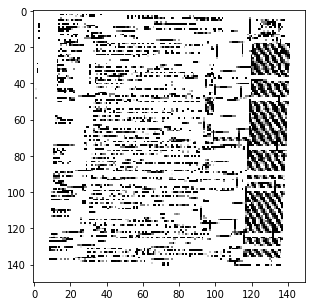

prediction: 0;  target: 0;  index = 811


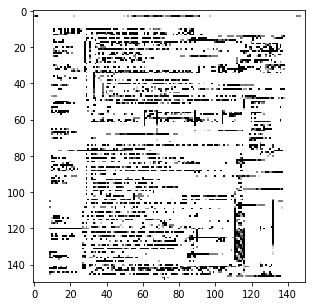

prediction: 8;  target: 8;  index = 1419


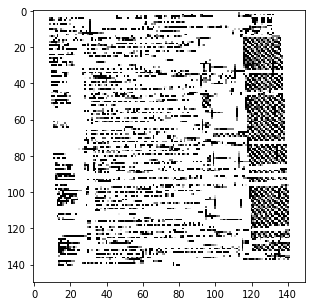

prediction: 0;  target: 6;  index = 2060


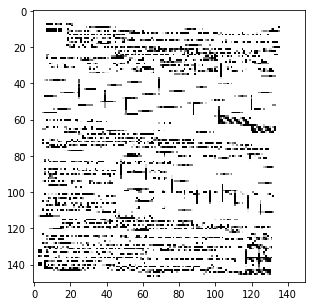

prediction: 4;  target: 10;  index = 2115


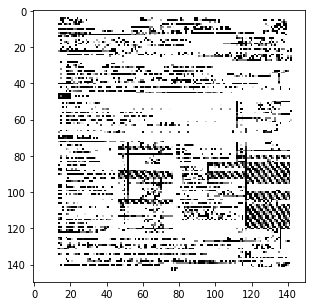

prediction: 8;  target: 15;  index = 3289


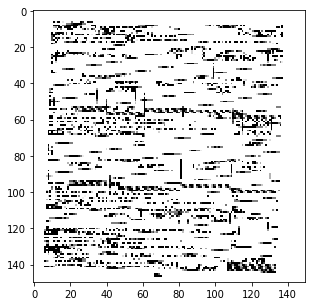

prediction: 8;  target: 8;  index = 3637


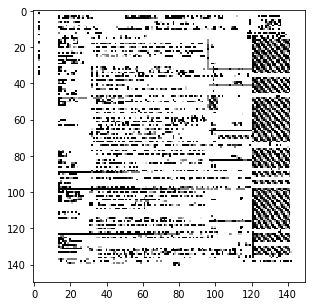

prediction: 8;  target: 14;  index = 4034


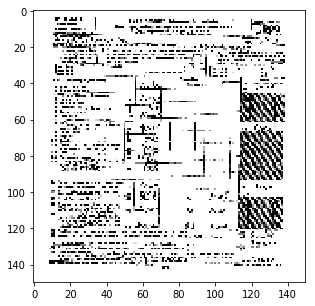

prediction: 10;  target: 8;  index = 4983


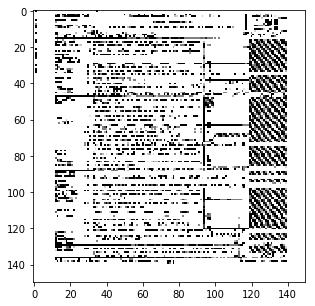

prediction: 8;  target: 6;  index = 5214


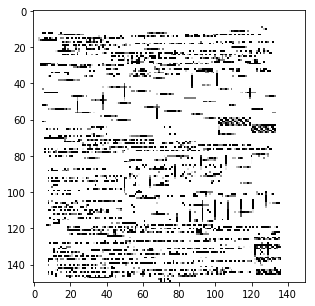

In [15]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

predictions = model.predict_classes(x_test)

i = 0
for pred in predictions:
    if pred != y_test[i].argmax():
        print('prediction: {0:d};  target: {1:d};  index = {2:d}'.format(pred, targets[i], i))
        display_image(images[i])
    i += 1
        

In [13]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1)

img = imread('nsu/11.jpg')  # this is a PIL image

x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='generated', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
